# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [1]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions

In [2]:

from jaxns import Prior, Model, Bernoulli

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p, name='predicates')
    return predicates, p[1]


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & 0.6 <= P(b) <= 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    #0.6 <= P(b) <= 0.9
    log_prob_1 = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9))
    log_prob_2 = jnp.where((p_B < 0.6) | (p_B > 0.9), -jnp.inf, 0.)
    log_prop = log_prob_1 + log_prob_2

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


INFO[2023-12-11 13:47:25,885]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:25,885]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:25,886]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 13:47:25,887]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
INFO[2023-12-11 13:47:26,462]: Sanity check...
INFO[2023-12-11 13:47:26,933]: Sanity check passed


In [3]:
import jax
from jaxns import DefaultNestedSampler

# Run the nested sampling
ns = DefaultNestedSampler(model=model, max_samples=1e5, difficult_model=True, parameter_estimation=True)

term_reason, state = jax.jit(ns)(random.PRNGKey(3452345))
results = ns.to_results(termination_reason=term_reason, state=state)

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


--------
Termination Conditions:
Small remaining evidence
All live-points are on a single plateau (potential numerical errors, consider 64-bit)
--------
likelihood evals: 48652
samples: 1500
phantom samples: 0.0
likelihood evals / sample: 32.4
phantom fraction (%): 0.0%
--------
logZ=-1.145 +- 0.044
H=2.0
ESS=282.1933288574219
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.45 +- 0.29 | 0.08 / 0.4 / 0.85 | 0.02 | 0.04
p[1]: 0.736 +- 0.088 | 0.628 / 0.722 / 0.872 | 0.88 | 0.659
p[2]: 0.54 +- 0.28 | 0.14 / 0.54 / 0.92 | 0.01 | 0.88
--------
predicates[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
predicates[0]: 0.35 +- 0.48 | 0.0 / 0.0 / 1.0 | 0.0 | 0.0
predicates[1]: 0.72 +- 0.45 | 0.0 / 1.0 / 1.0 | 1.0 | 0.0
predicates[2]: 0.55 +- 0.5 | 0.0 / 1.0 / 1.0 | 0.0 | 1.0
--------


WARNING[2023-12-11 13:47:33,519]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


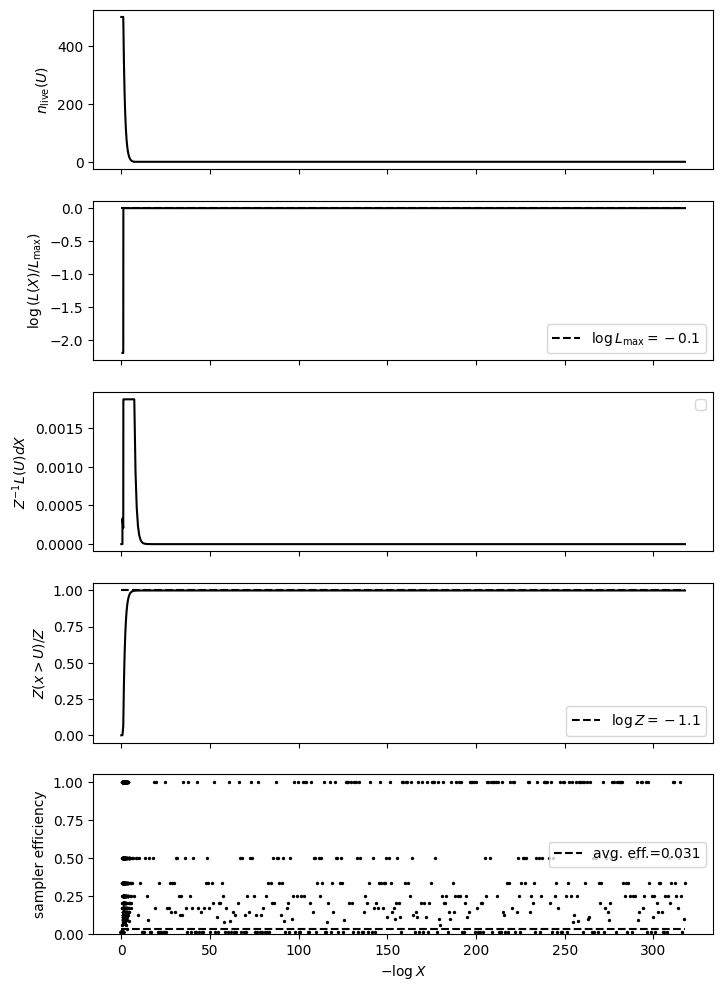

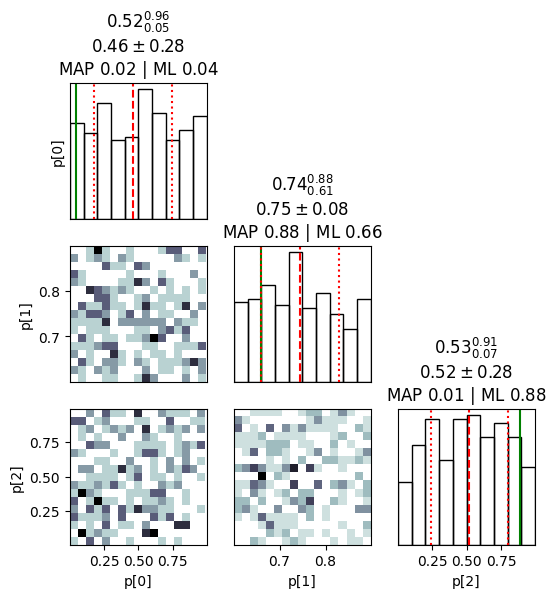

In [4]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results, vars=['p', 'p_B'])